In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets('data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [4]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]],'x_placeholder')
        
        #Adversarial part of the network
        self.attack = tf.Variable(tf.zeros([network_architecture["n_input"]], dtype=tf.float32),name='Attack')
        self.adversarial_x = self.x + self.attack
        self.target = tf.placeholder(tf.float32, [None, network_architecture["n_z"]],'target_z')
        
        # Create autoencoder network
        self._create_network()
        
        
        self.sess = tf.InteractiveSession()
        
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1),name='wrecog_h1'),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2),name='wrecag_h2'),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z),name='wrecog_out_mean'),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z),name='wrecog_out_log_sigma')}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32),name='brecog_b1'),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32),name='brecog_b2'),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32),name='brecog_out_mean'),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32),name='brecog_log_sigma')}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1),name='wgener_h1'),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2),name='wgener_h2'),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input),name='wgener_out_mean'),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input),name='wgener_log_sigma')}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32),name='bgener_b1'),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32),name='bgener_b2'),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32),name='bgener_out_mean'),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32),name='bgener_log_sigma')}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.adversarial_x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        
        #getting variables that are not form the attack
        all_vars = self.sess.graph.get_collection('trainable_variables')
        w = [var for var in all_vars if 'Attack' not in var.name]
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost,var_list=w)
        
        
        self.target_cost = tf.square(self.target - self.z_mean)
        
        #Adversarial optimizer
        self.adversarial_optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.target_cost,
                                                                              var_list=[self.attack])
    
    def reset_attack(self):
        
        tf.zeros([network_architecture["n_input"]], dtype=tf.float32)
    
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [5]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print ("EPOCH: %04d, COST: %.5f" % (epoch+1, avg_cost))
    return vae

In [6]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

EPOCH: 0001, COST: 175.34374
EPOCH: 0006, COST: 108.91950
EPOCH: 0011, COST: 104.55827
EPOCH: 0016, COST: 102.40041
EPOCH: 0021, COST: 101.03344
EPOCH: 0026, COST: 100.00577
EPOCH: 0031, COST: 99.10944
EPOCH: 0036, COST: 98.24902
EPOCH: 0041, COST: 97.57344
EPOCH: 0046, COST: 97.02067
EPOCH: 0051, COST: 96.57103
EPOCH: 0056, COST: 96.16222
EPOCH: 0061, COST: 95.80844
EPOCH: 0066, COST: 95.49943
EPOCH: 0071, COST: 95.25433


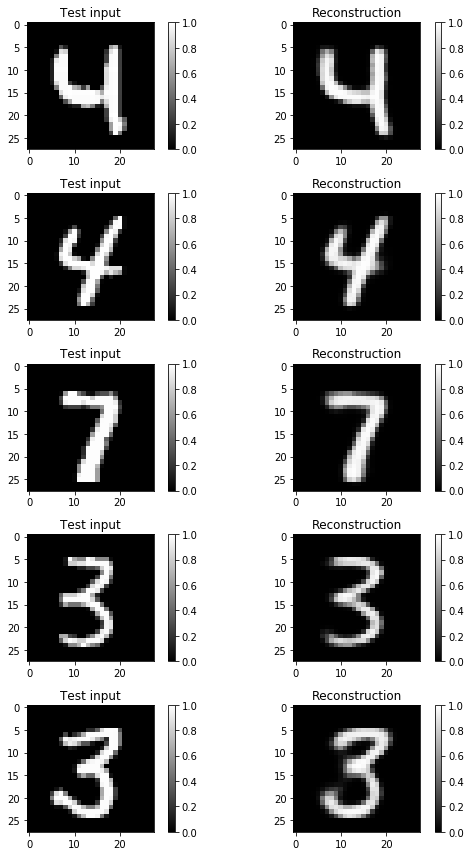

In [7]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

# Adversarial Attack

In [8]:
i = 4
original = np.array([x_sample[1]])
target = np.array([x_sample[4]])
z_target = vae.transform(target)
original_reconstruction = vae.reconstruct(original) 

feed_dict={vae.x:original,vae.target:z_target}

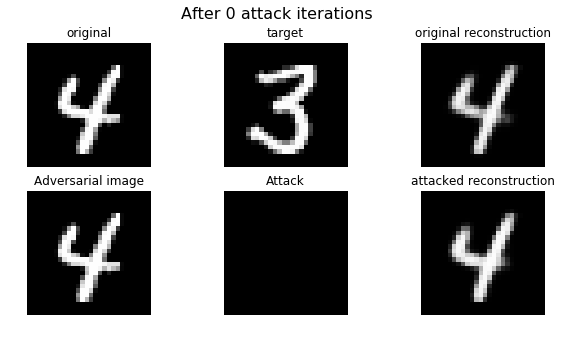

0.924581


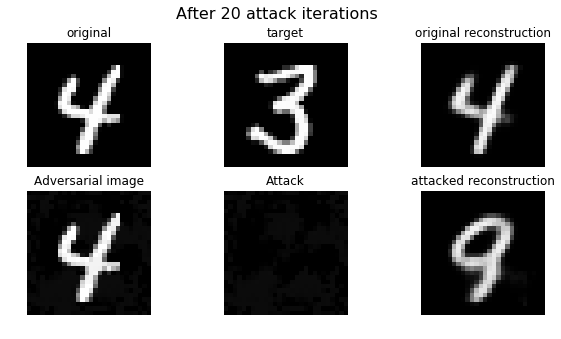

0.443327


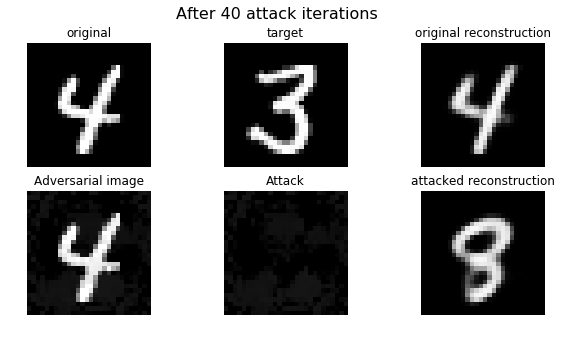

0.277896


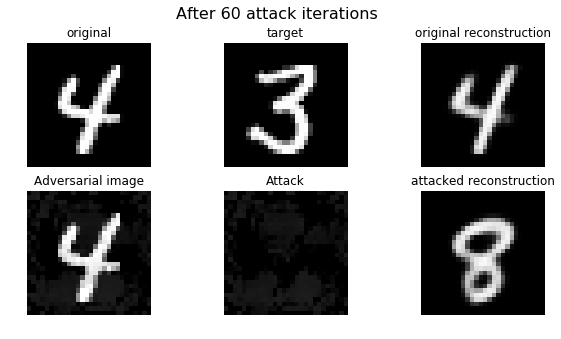

0.194679


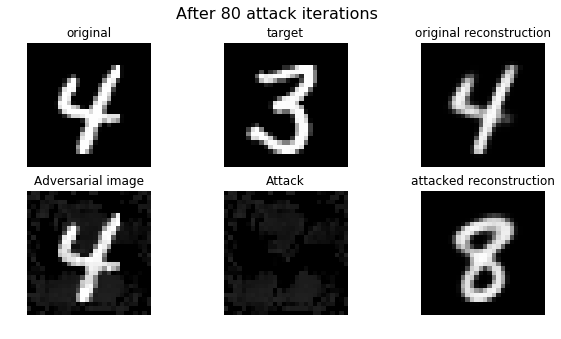

0.135224


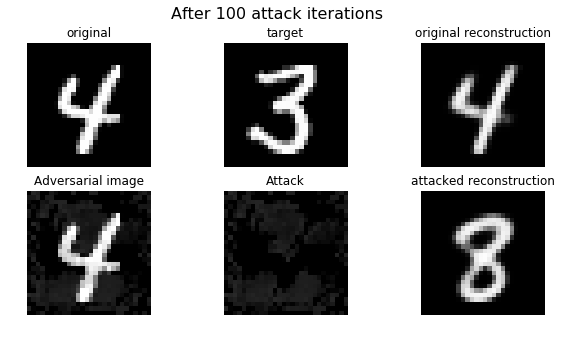

0.0822977


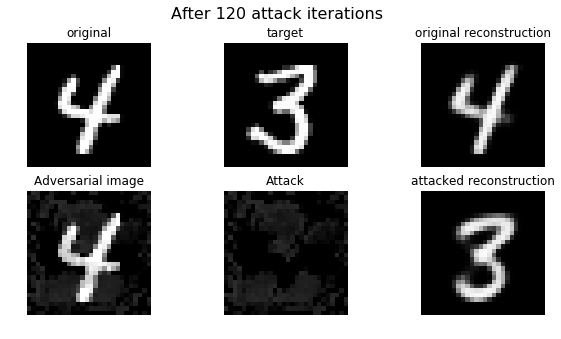

0.0369193


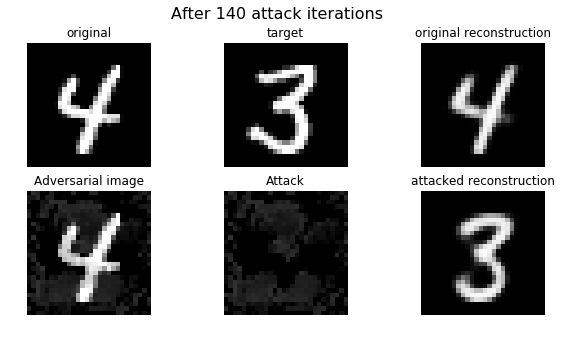

0.0120384


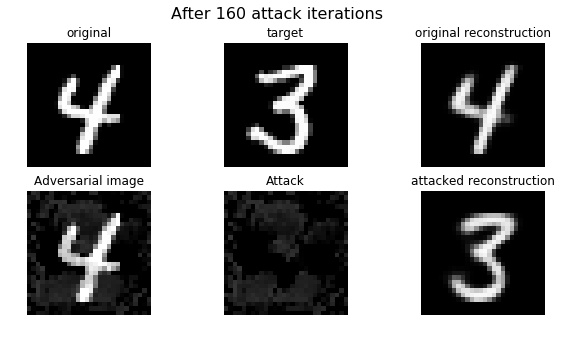

0.00673631


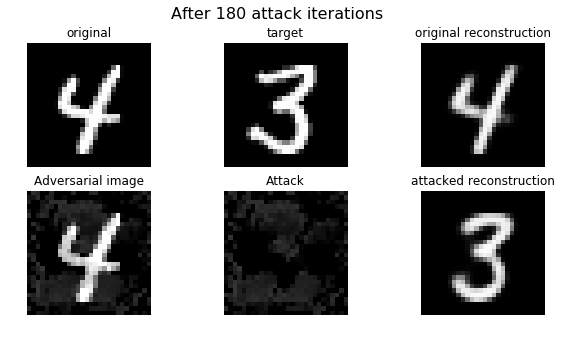

0.00444922


In [29]:
vae.sess.run(tf.variables_initializer([vae.attack]))
attack_iterations = 0
for i in range(10):
    adv_cost = vae.sess.run(vae.target_cost, feed_dict=feed_dict)
    reconstruction = vae.reconstruct(original)
    attack = vae.sess.run(vae.attack)
    adversarial_image = vae.sess.run(vae.adversarial_x,feed_dict)
    
    
    plt.figure(figsize=(10,5))
    plt.suptitle('After %d attack iterations' % attack_iterations,fontsize=16)
    plt.subplot(231)
    plt.imshow(original.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title('original')
    plt.axis('off')
    plt.subplot(232)
    plt.imshow(target.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title('target')
    plt.axis('off')
    plt.subplot(233)
    plt.imshow(original_reconstruction[0].reshape(28,28),vmin=0,vmax=1,cmap='gray')
    plt.title('original reconstruction')
    plt.axis('off')
    plt.subplot(234)
    plt.imshow(adversarial_image.reshape(28,28),vmin=0,vmax=1,cmap='gray')
    plt.title('Adversarial image')
    plt.axis('off')
    plt.subplot(235)
    plt.imshow(attack.reshape(28,28),vmin=0,vmax=1,cmap='gray')
    plt.title('Attack')
    plt.axis('off')
    plt.subplot(236)
    plt.imshow(reconstruction[0].reshape(28,28),vmin=0,vmax=1,cmap='gray')
    plt.title('attacked reconstruction')
    plt.axis('off')
    plt.show()
    print(np.mean(adv_cost))
    for i in range(20):
        vae.sess.run(vae.adversarial_optimizer,feed_dict=feed_dict)
        attack_iterations += 1

In [ ]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

In [ ]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()